# 📘 Forecasting Migration Flows — **Notebook 04: Model Interpretation and Scenario Analysis**

| **Author** | Golib Sanaev |
|-------------|--------------|
| **Project** | Forecasting Migration Flows with Machine Learning |
| **Created** | 2025-09-23 |
| **Last Updated** | 2025-10-14 |

---

### 🎯 **Purpose**

This notebook focuses on **model interpretation** and **scenario simulations** for global migration flow predictions. It builds on the trained Random Forest model from [**Notebook 03: Feature Engineering and Modeling**](03-feature-engineering-modeling.html), translating statistical patterns into interpretable and policy-relevant insights.

We connect **feature-level explanations** (via SHAP) with **regional** and **scenario-based** analyses to understand how socioeconomic and demographic conditions shape predicted migration flows.

**Key interpretability components**
- **Permutation importance** — global feature contributions  
- **SHAP values** — nonlinear and directional effects  
- **Regional sensitivity** — how model responses vary by region  
- **Scenario simulations** — “what-if” experiments for policy insight  

---

<a id="top"></a>
## 📑 Table of Contents

- [🌲 2. Global Feature Importance — Random Forest](#global-feature-importance)
- [🧠 3. Model Explainability with SHAP](#model-explainability)
  - [🧩 3.1. SHAP Setup (TreeExplainer)](#shap-setup)
  - [🔍 3.2. Global SHAP Feature Importance](#global-shap-importance)
  - [↕️ 3.3. Feature-Level Direction and Strength](#feature-direction)
  - [📈 3.4. SHAP Dependence Plots](#shap-dependence)
  - [🌍 3.5. Regional Sensitivity Analysis](#regional-sensitivity)
  - [🗺️ 3.6. Regional Composition — Top-5 Drivers](#regional-top5)
  - [💧 3.7. Local Explanations — Waterfall Plots](#local-waterfall)
- [🧪 4. Scenario Simulation Experiments](#scenario-simulation)
  - [💹 4.1. GDP Growth Shocks](#gdp-shocks)
  - [👥 4.2. Demographic and Development Shifts](#demographic-shifts)
  - [🚀 4.3. Scenario Runner — Global, Regional and Local Δ](#scenario-runner)
  - [📊 4.4. Top Movers — Country-Year Highlights](#top-movers)
- [🧭 5. Regional Feature Context](#regional-context)
- [🧾 6. Key Insights and Next Steps](#key-insights)


---

## ⚙️ 1. Setup and Load Model-Ready Data

Load the finalized feature matrix and trained Random Forest model from [**Notebook 03: Feature Engineering and Modeling**](03-feature-engineering-modeling.html) for interpretation and scenario analysis.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [1]:
# === Setup and Load Model-Ready Data ===

import warnings

# --- Ignore only relevant harmless warnings ---
warnings.filterwarnings("ignore", message="An input array is constant")  # from SHAP/Spearman correlation

# --- Core libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.inspection import permutation_importance
from pathlib import Path
import random

# --- Visualization style ---
sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.facecolor": "white", "axes.facecolor": "white"})

# --- Paths ---
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

# --- Load contextual metadata for later grouping ---
df_context = pd.read_csv(DATA_DIR / "countries_clean.csv")[["Country Name", "year", "Region", "IncomeGroup"]]

# --- Load model-ready dataset and trained model ---
df_model = pd.read_csv(DATA_DIR / "model_ready.csv")
model = joblib.load(MODEL_DIR / "random_forest_model.pkl")
X_columns = joblib.load(MODEL_DIR / "X_columns.pkl")

# --- Ensure feature alignment ---
missing_cols = [c for c in X_columns if c not in df_model.columns]
for c in missing_cols:
    df_model[c] = 0

X = df_model.reindex(columns=X_columns, fill_value=0).copy()
y = df_model["net_migration_per_1000_capped"].copy()

print(f"✅ Model-ready data loaded and aligned — {len(X_columns)} predictors")
print(f"Feature matrix shape: {X.shape}")

✅ Model-ready data loaded and aligned — 25 predictors
Feature matrix shape: (5712, 25)


## 🌲 2. Global Feature Importance — Random Forest <a id="global-feature-importance"></a>  

Assess which predictors most strongly influence migration predictions in the trained Random Forest model. **Permutation importance (Model-Level Baseline)** is computed by repeatedly shuffling each feature to measure how much it degrades model performance — higher values indicate stronger predictive contribution.

**Objectives:**
- Quantify **global feature influence** across all observations  
- Visualize the **top 15 drivers** of predicted migration outcomes  
- Establish a baseline for comparison with SHAP-based explainability in later sections  

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

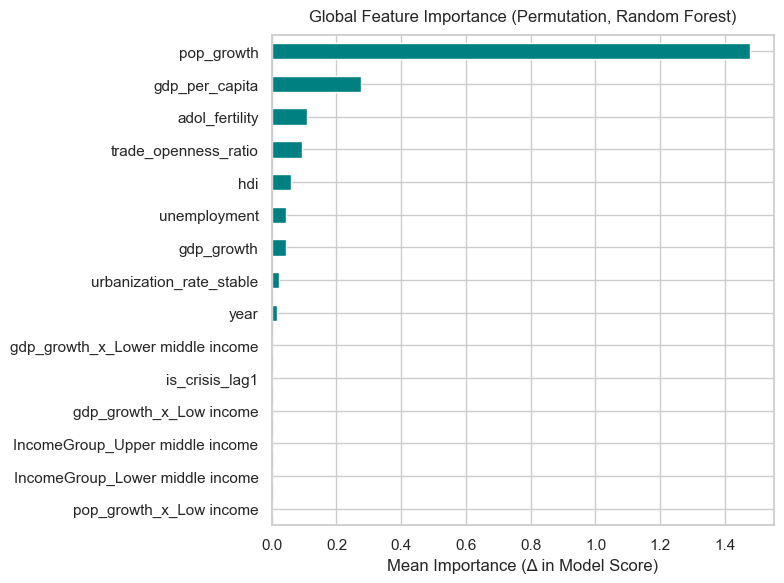

,Mean Importance
pop_growth,1.4774
gdp_per_capita,0.2761
adol_fertility,0.1097
trade_openness_ratio,0.0922
hdi,0.0592
unemployment,0.0456
gdp_growth,0.0451
urbanization_rate_stable,0.0226
year,0.0163
gdp_growth_x_Low income,0.0000


In [2]:
# === Global Feature Importance — Random Forest ===

# --- Compute permutation importance ---
perm = permutation_importance(
    model,
    X,
    y,
    n_repeats=10,
    random_state=42
)

# --- Sort and convert to Series for easier visualization ---
imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=True)

# --- Plot top 15 most important features ---
plt.figure(figsize=(8, 6))
imp.tail(15).plot(kind="barh", color="teal")

plt.title("Global Feature Importance (Permutation, Random Forest)", pad=10)
plt.xlabel("Mean Importance (Δ in Model Score)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- Display top-ranked features as a table ---
top_features = imp.sort_values(ascending=False).head(15).round(4).to_frame("Mean Importance")
display(top_features)

> **Interpretation:**  
> The Random Forest identifies **HDI**, **population growth**, and **adolescent fertility** as leading migration predictors.  
> Economic variables such as **trade openness** and **GDP growth** also contribute substantially, capturing both development and opportunity effects.

## 🧠 3. Model Explainability with SHAP <a id="model-explainability"></a>    

To complement global permutation importance, this section applies **SHAP (SHapley Additive exPlanations)** to uncover both the **magnitude** and **direction** of feature effects. SHAP provides a consistent framework for interpreting how each variable contributes to individual predictions — capturing **nonlinearities** and **interactions** that tree-based models naturally learn.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

### 🧩 3.1. SHAP Setup (TreeExplainer) <a id="shap-setup"></a>  

Initialize the SHAP explainer for the trained Random Forest model and compute SHAP values for a representative random sample of observations. Sampling helps reduce computation time while preserving interpretability quality.

**Steps included:**
- Load and subsample the feature matrix (`n=500`)  
- Compute SHAP values using `TreeExplainer`  
- Store feature names and expected value for later use in plots

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [3]:
# === SHAP Explainability Setup (TreeExplainer) ===

# --- Sample manageable subset for visualization ---
X_sample = X.sample(n=500, random_state=42).astype(np.float32)

# --- Initialize SHAP TreeExplainer for Random Forest ---
# (check_additivity=False → faster and safe for tree-based models)
explainer = shap.TreeExplainer(model)

# --- Compute SHAP values ---
shap_values = explainer.shap_values(X_sample, check_additivity=False)

# --- Extract metadata for downstream use ---
feature_names = X_sample.columns.tolist()
expected_value = (
    explainer.expected_value[0]
    if isinstance(explainer.expected_value, (list, np.ndarray))
    else explainer.expected_value
)

print(f"✅ SHAP values computed for {len(X_sample)} samples and {len(feature_names)} features.")

✅ SHAP values computed for 500 samples and 25 features.


> A random 500-row subset is used to accelerate SHAP computations while maintaining representativeness.  
> This ensures interpretable feature-level explanations without excessive memory or runtime cost.


### 🔍 3.2. Global SHAP Feature Importance <a id="global-shap-importance"></a>  

Evaluate how strongly each variable contributes to the model’s predictions across all samples using **mean absolute SHAP values**. This approach complements permutation importance by quantifying **average feature impact** directly from model internals rather than external perturbation.

Two complementary visualizations are generated:

- **Bar plot** — ranks features by their average absolute SHAP value (global influence).  
- **Beeswarm plot** — displays the distribution and direction (positive or negative) of SHAP values per feature, revealing nonlinear or asymmetric effects.  

Together, these charts provide a holistic view of which predictors consistently drive migration outcomes and how their effects vary across contexts.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

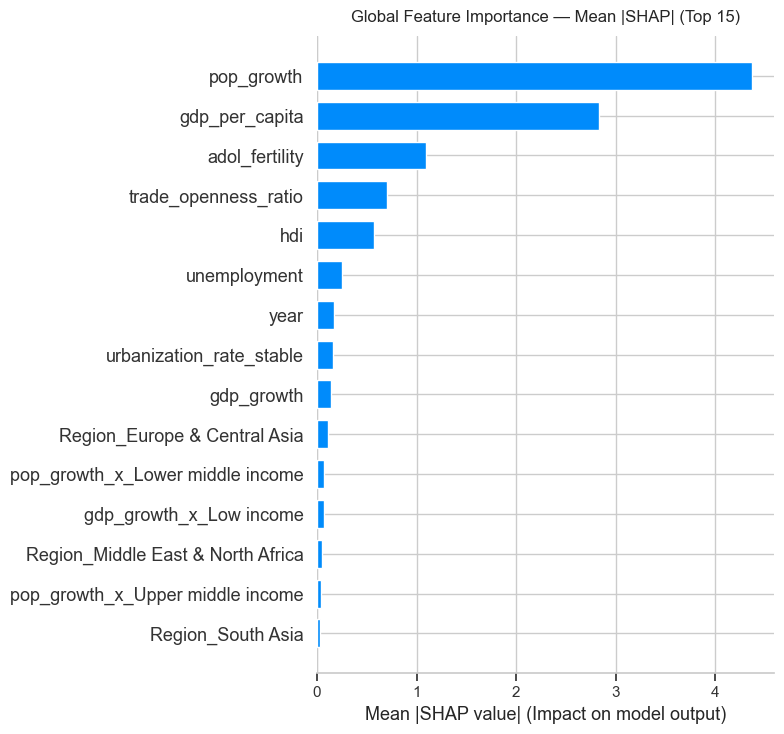

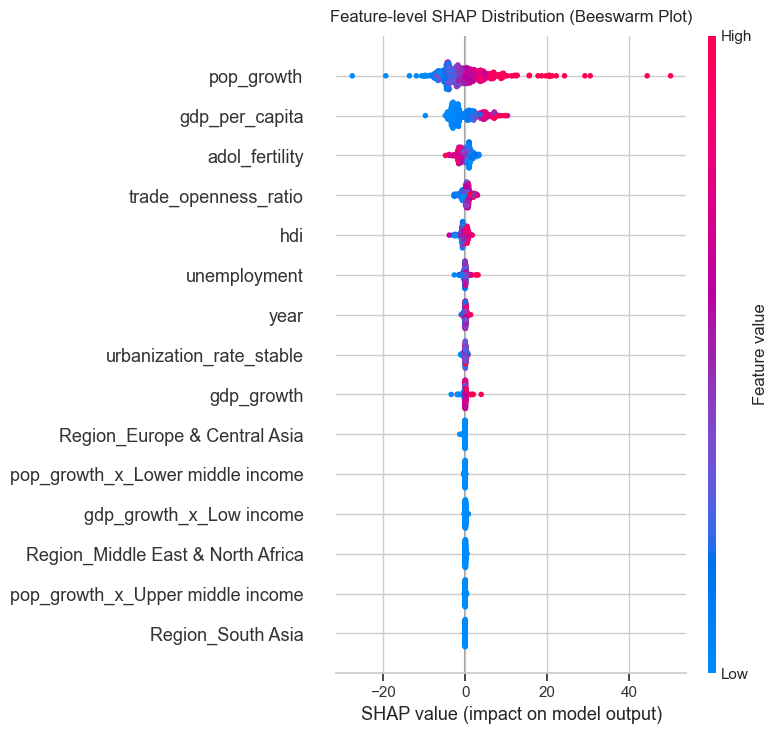

In [4]:
# === Global SHAP Feature Importance ===

# --- Mean absolute SHAP values (global impact ranking) ---
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Global Feature Importance — Mean |SHAP| (Top 15)", pad=10)
plt.xlabel("Mean |SHAP value| (Impact on model output)")
plt.tight_layout()
plt.show()

# --- Beeswarm plot (distribution of SHAP effects across samples) ---
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_sample,
    max_display=15,
    show=False
)
plt.title("Feature-level SHAP Distribution (Beeswarm Plot)", pad=10)
plt.tight_layout()
plt.show()

> **Interpretation:**  
> The bar and beeswarm SHAP plots summarize how much each feature contributes to model predictions:  
> - The bar plot ranks features by their **mean absolute SHAP impact** (importance magnitude).  
> - The beeswarm plot adds directional detail — **red dots** show samples where higher feature values push predictions up (toward higher migration inflows), while **blue dots** show the opposite.  
>  
> This view reveals the most influential predictors across all countries and years, capturing both size and sign of their effects.

### ↕️ 3.3. Feature-Level Direction and Strength <a id="feature-direction"></a>  

Beyond global averages, it is useful to understand **how** each feature influences predictions — whether higher values increase or decrease migration inflows.

This section summarizes two key dimensions of feature behavior:

| Metric | Description |
|---------|-------------|
| **mean \|SHAP\|** | Average magnitude of impact (overall importance). |
| **Spearman correlation** | Indicates direction: positive values mean that higher feature values raise predicted net migration; negative values imply the opposite. |

The resulting table ranks the top predictors by impact strength and sign, providing a concise overview suitable for reports or presentations.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [5]:
# === Feature-Level SHAP Direction and Strength ===

# --- Convert SHAP values to DataFrame for analysis ---
sv = pd.DataFrame(shap_values, columns=feature_names, index=X_sample.index)

# --- Mean absolute SHAP values (magnitude of importance) ---
abs_mean = sv.abs().mean().sort_values(ascending=False)

# --- Directionality: Spearman correlation (feature ↔ SHAP value) ---
dirs = pd.Series(
    {f: X_sample[f].corr(sv[f], method="spearman") for f in feature_names}
).reindex(abs_mean.index)

# --- Combine into summary table ---
top_features = (
    pd.DataFrame({
        "mean_|SHAP|": abs_mean,
        "direction (Spearman)": dirs
    })
    .round(4)
    .head(15)
)

# --- Display styled table ---
display(
    top_features.style
        .background_gradient(subset=["mean_|SHAP|"], cmap="Blues")
        .set_caption("Top 15 Features — SHAP Magnitude and Direction")
)

,mean_|SHAP|,direction (Spearman)
pop_growth,4.370800,0.968000
gdp_per_capita,2.833600,0.908700
adol_fertility,1.099100,-0.870600
trade_openness_ratio,0.703000,0.780600
hdi,0.575600,0.839600
unemployment,0.256000,0.480400
year,0.168400,0.677100
urbanization_rate_stable,0.161100,0.392700
gdp_growth,0.142800,0.811700
Region_Europe & Central Asia,0.106900,nan


### 📈 3.4. SHAP Dependence Plots <a id="shap-dependence"></a>  

Visualize **how feature values relate to their SHAP impacts** to uncover potential **nonlinearities** and **interactions** in model behavior. Each plot shows how changes in a single feature influence predicted migration, colored by the most strongly interacting variable.

Key insights this view enables:
- Detect **thresholds** (e.g., when GDP growth becomes a migration pull factor).  
- Identify **interaction effects** (e.g., HDI impact varying by income group).  
- Reveal **non-monotonic trends** often hidden in aggregate metrics.

Dependence plots help bridge global importance with interpretable, feature-level response patterns — making nonlinear effects visually intuitive.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

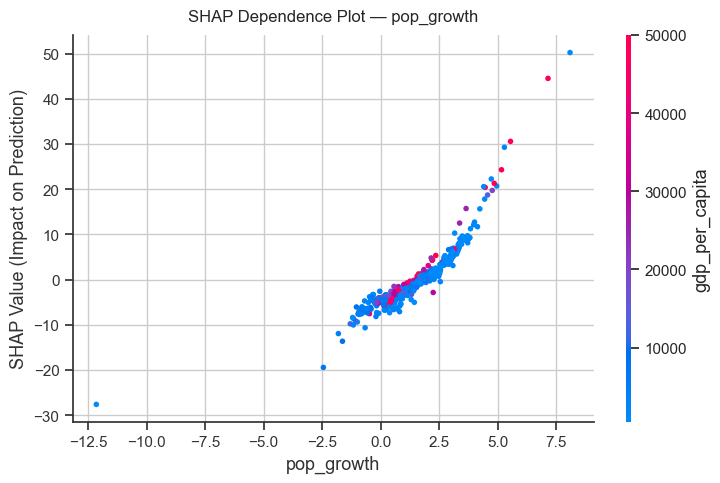

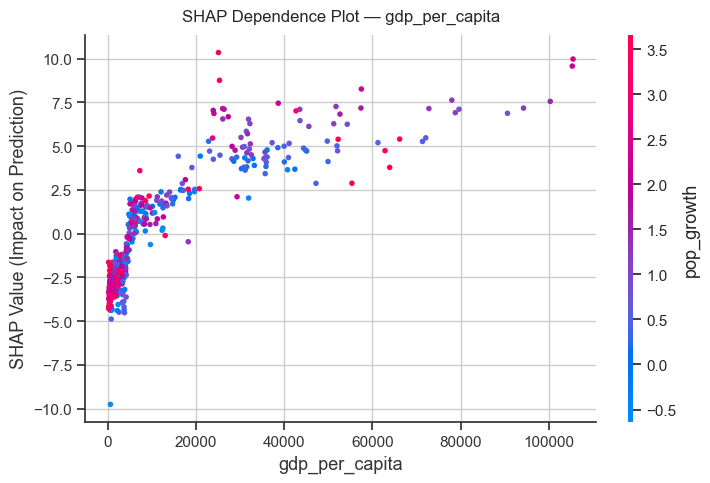

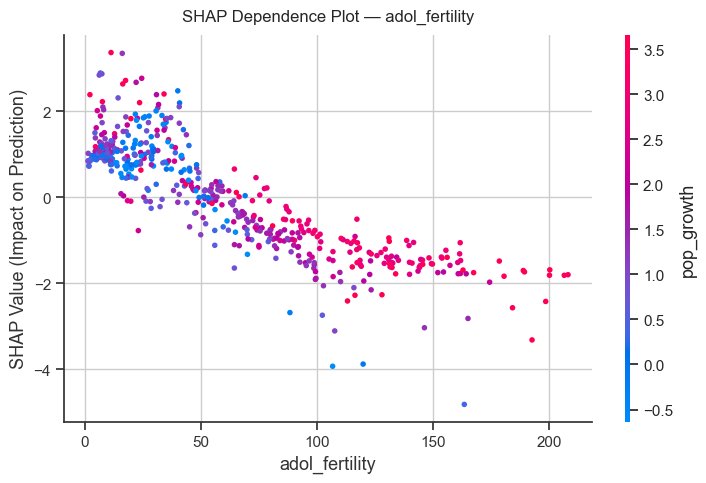

In [6]:
# === SHAP Dependence Plots (Top Features) ===

# --- Select top 2–3 features by global SHAP importance ---
top_features = list(top_features.index[:3])  # top 3 for richer comparison

# --- Generate SHAP dependence plots with automatic interaction highlighting ---
for f in top_features:
    shap.dependence_plot(
        f,
        shap_values,
        X_sample,
        interaction_index="auto",  # auto-selects strongest interacting variable
        show=False
    )
    plt.title(f"SHAP Dependence Plot — {f}", fontsize=12, pad=10)
    plt.xlabel(f)
    plt.ylabel("SHAP Value (Impact on Prediction)")
    plt.tight_layout()
    plt.show()

### 🌍 3.5. Regional Sensitivity Analysis <a id="regional-sensitivity"></a>  

Aggregate SHAP values by **world region** to examine how the model’s feature sensitivities vary geographically. By averaging absolute SHAP values within each region, we can identify **which drivers matter most** across different migration contexts.

This analysis highlights:
- **Regional heterogeneity** — features influencing migration differ between, for example, Sub-Saharan Africa and Europe & Central Asia.  
- **Context-specific dynamics** — demographic pressure may dominate in low-income regions, while economic or development variables drive high-income migration patterns.  
- **Model robustness** — consistent top drivers across regions reinforce generalizable relationships.

The resulting heatmap visualizes the relative feature importance across regions, offering a diagnostic view of the model’s spatial interpretability.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

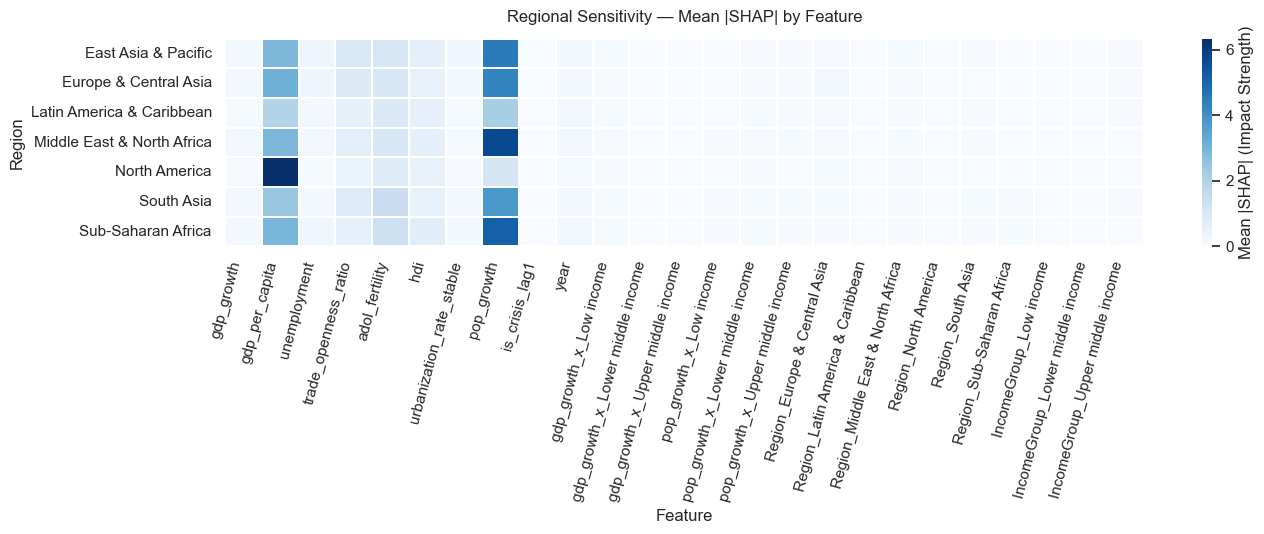

,Top 5 Drivers
Region,
East Asia & Pacific,"['pop_growth', 'gdp_per_capita', 'adol_fertility', 'trade_openness_ratio', 'hdi']"
Europe & Central Asia,"['pop_growth', 'gdp_per_capita', 'adol_fertility', 'trade_openness_ratio', 'hdi']"
Latin America & Caribbean,"['pop_growth', 'gdp_per_capita', 'adol_fertility', 'trade_openness_ratio', 'hdi']"
Middle East & North Africa,"['pop_growth', 'gdp_per_capita', 'adol_fertility', 'trade_openness_ratio', 'hdi']"
North America,"['gdp_per_capita', 'pop_growth', 'adol_fertility', 'hdi', 'trade_openness_ratio']"
South Asia,"['pop_growth', 'gdp_per_capita', 'adol_fertility', 'trade_openness_ratio', 'hdi']"
Sub-Saharan Africa,"['pop_growth', 'gdp_per_capita', 'adol_fertility', 'hdi', 'trade_openness_ratio']"


In [7]:
# === Regional Sensitivity Analysis — Mean |SHAP| by Feature ===

# --- Compute regional mean absolute SHAP impacts ---
sv_abs = sv.abs().copy()

# Map regions from df_context (index-aligned sample)
sv_abs["Region"] = df_context.loc[X_sample.index, "Region"].values

# --- Aggregate mean absolute SHAP values by region ---
region_shap = (
    sv_abs.groupby("Region", dropna=False)[feature_names]
    .mean()
    .sort_index()
)

# --- Visualization: Heatmap of regional mean |SHAP| ---
fig, ax = plt.subplots(
    figsize=(min(14, 0.5 * len(region_shap.columns) + 4), 0.5 * len(region_shap) + 2)
)

sns.heatmap(
    region_shap,
    cmap="Blues",
    cbar_kws={"label": "Mean |SHAP| (Impact Strength)"},
    linewidths=0.3,
    ax=ax
)

ax.set_title("Regional Sensitivity — Mean |SHAP| by Feature", pad=12)
ax.set_xlabel("Feature")
ax.set_ylabel("Region")

plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# --- Show top 5 features per region for inspection ---
top_per_region = (
    region_shap.apply(lambda r: r.sort_values(ascending=False).head(5).index.tolist(), axis=1)
    .rename("Top 5 Drivers")
    .to_frame()
)

display(top_per_region.style.set_caption("Top 5 SHAP Drivers by Region"))

> **Interpretation:**  
> The heatmap shows how strongly each feature influences predictions **within each world region**, using the average absolute SHAP values.  
> - Darker colors indicate stronger model sensitivity to that feature in the given region.  
> - **HDI** and **GDP growth** dominate in *Europe & Central Asia* and *North America*.  
> - **Adolescent fertility** and **population growth** are stronger drivers in *Sub-Saharan Africa* and *South Asia*, reflecting demographic pressure.  
>  
> The accompanying table lists each region’s **Top 5 SHAP drivers**, revealing where feature effects differ most across the world.

### 🗺️ 3.6. Regional Composition — Top-5 Drivers <a id="regional-top5"></a>  

This step examines how the **relative contribution** of the most influential features differs by region. By normalizing the mean absolute SHAP values within each region, we estimate **the share of total model sensitivity** attributed to the top-5 global drivers.

Analytical goals:
- Identify **dominant drivers** in each region (e.g., adolescent fertility or HDI).  
- Reveal **structural contrasts** — some regions’ migration patterns depend more on development factors, others on demographic or trade indicators.  
- Quantify **feature mix diversity** across world regions.

The stacked bar chart illustrates how each region’s migration sensitivity is distributed across its top-5 explanatory variables, offering a comparative lens on regional migration mechanisms.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

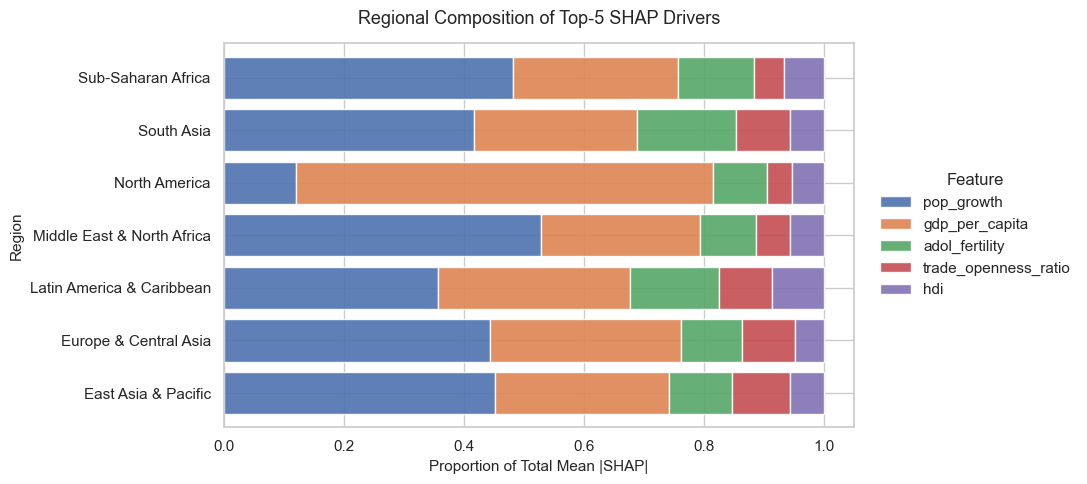

In [8]:
# === Regional Composition — Share of Total Mean |SHAP| (Top-5 Drivers) ===

# --- Identify Top-5 Globally Most Influential Features ---
top_features = region_shap.mean().sort_values(ascending=False).head(5).index

# --- Compute Each Region’s Proportional Share of These Drivers ---
region_share = region_shap[top_features].div(region_shap[top_features].sum(axis=1), axis=0)

# --- Visualization ---
ax = region_share.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 5),
    width=0.8,
    alpha=0.9,
)

plt.title("Regional Composition of Top-5 SHAP Drivers", fontsize=13, pad=14)
plt.xlabel("Proportion of Total Mean |SHAP|", fontsize=11)
plt.ylabel("Region", fontsize=11)
plt.tight_layout(rect=[0, 0, 0.78, 1])  # Add right margin for legend

# --- Legend Styling (placed outside the plot) ---
plt.legend(
    title="Feature",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    frameon=False,
)

# Adjust spacing between bars and legend area
plt.subplots_adjust(left=0.15, right=0.78)
plt.show()

> **Interpretation:**  
> The relative importance of top-5 SHAP drivers varies by region.  
> *Population growth* dominates in Sub-Saharan Africa, while *HDI* and *trade openness* explain a greater share of migration variation in advanced economies.

### 💧 3.7. Local Explanations — Waterfall Plots <a id="local-waterfall"></a>  

Explore **individual predictions** to understand how specific feature profiles drive migration outcomes in the model. Each SHAP waterfall plot decomposes a single prediction into **additive feature contributions** relative to the global baseline.

Analytical purpose:
- Illustrate how the model **balances push and pull factors** for given country–year cases.  
- Identify **dominant local drivers** behind extreme inflows or outflows.  
- Validate whether predictions align with plausible migration logic (e.g., high adolescent fertility and low HDI → outflows).

Interpretation guide:
- **Gray baseline:** model’s expected (average) prediction.  
- **Red bars:** features pushing migration **up** (toward inflows).  
- **Blue bars:** features pushing migration **down** (toward outflows).

**Note:**  
Waterfall plots below decompose three sample predictions, showing how individual features raise (red) or lower (blue) predicted migration outcomes relative to the global average.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---


💧 Local SHAP Waterfall — Sample Index: 3904


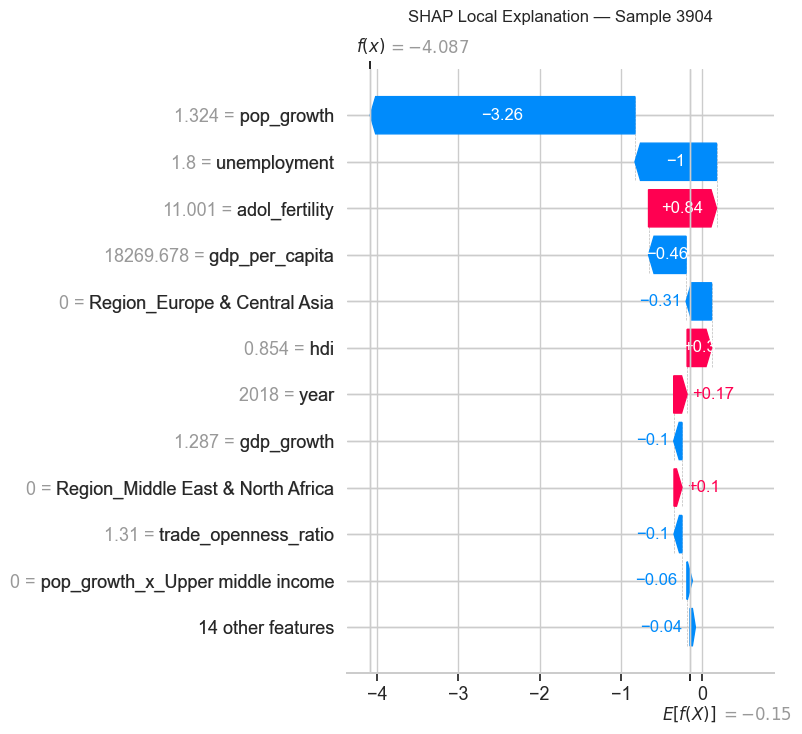


💧 Local SHAP Waterfall — Sample Index: 577


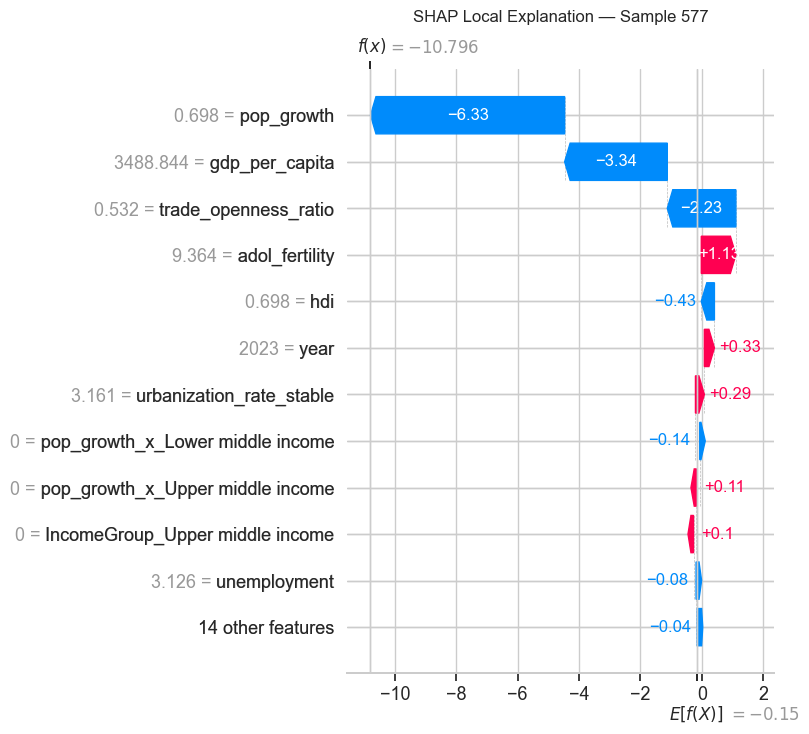


💧 Local SHAP Waterfall — Sample Index: 2209


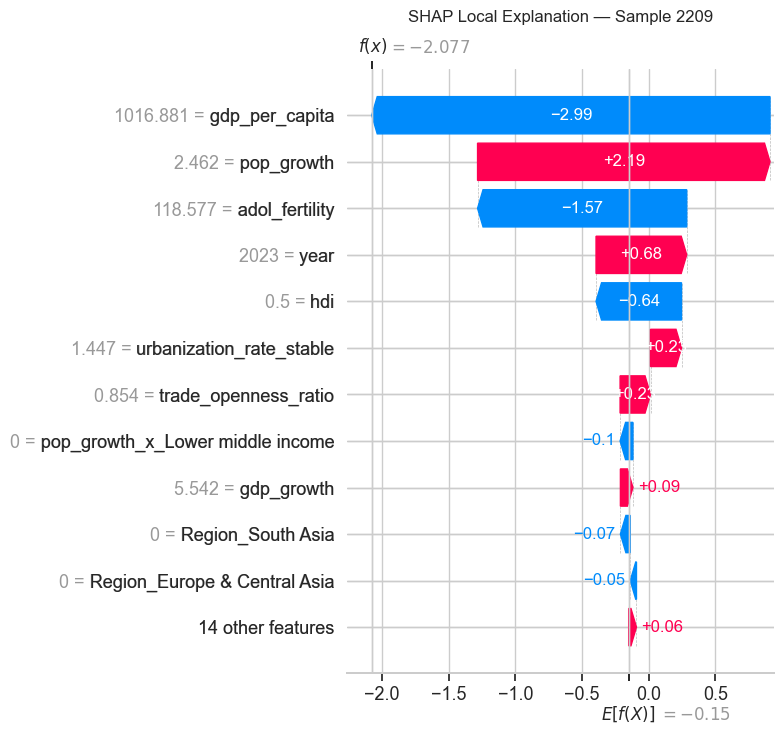

In [9]:
# === Local Explanations — SHAP Waterfall Plots (3 Random Samples) ===

# --- Convert expected value to scalar (if array-like) ---
expected_value_scalar = (
    explainer.expected_value[0]
    if isinstance(explainer.expected_value, (list, np.ndarray))
    else explainer.expected_value
)

# --- Reproducible random selection of samples ---
random.seed(42)
idxs = random.sample(list(X_sample.index), 3)

# --- Try new SHAP API; fall back to legacy if needed for static HTML ---
try:
    from shap.plots import waterfall as shap_waterfall_new
    use_legacy = False
except Exception:
    use_legacy = True

if use_legacy:
    # Legacy import for maximum compatibility with nbconvert/HTML export
    try:
        from shap.plots._waterfall import waterfall_legacy as shap_waterfall_legacy
    except Exception as e:
        print(f"⚠️ Could not import legacy waterfall plotter: {e}")
        shap_waterfall_legacy = None

for i in idxs:
    print(f"\n💧 Local SHAP Waterfall — Sample Index: {i}")

    # Ensure plain numpy arrays for plotting stability
    sample_features = X_sample.loc[i].to_numpy()
    sample_feature_names = list(X_sample.columns)
    sample_values = sv.loc[i].to_numpy()

    # New API path (preferred)
    if not use_legacy:
        exp = shap.Explanation(
            values=sample_values.astype(float),
            base_values=float(expected_value_scalar),
            data=sample_features.astype(float),
            feature_names=sample_feature_names,
        )
        # Use show=False so nbconvert captures the Matplotlib figure
        shap.plots.waterfall(exp, max_display=12, show=False)
        plt.title(f"SHAP Local Explanation — Sample {i}", pad=10)
        plt.tight_layout()
        plt.show()
    else:
        # Legacy fallback (still matplotlib-based)
        if shap_waterfall_legacy is not None:
            shap_waterfall_legacy(
                shap_values=sample_values.astype(float),
                feature_names=sample_feature_names,
                max_display=12,
                show=False,
                expected_value=float(expected_value_scalar),
                features=sample_features.astype(float),
            )
            plt.title(f"SHAP Local Explanation — Sample {i}", pad=10)
            plt.tight_layout()
            plt.show()
        else:
            print("❌ Skipping plot: no compatible SHAP waterfall function available.")

## 🧪 4. Scenario Simulation Experiments <a id="scenario-simulation"></a>  

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

### 💹 4.1. GDP Growth Shocks <a id="gdp-shocks"></a>  

Test how simulated **macroeconomic changes**—specifically shifts in GDP growth—affect predicted migration flows. By adjusting GDP growth ±2 percentage points from the baseline, we assess how sensitive migration forecasts are to economic expansion or contraction.

Analytical purpose:
- Quantify **elasticity** of migration with respect to short-term GDP shocks.  
- Observe whether economic improvements lead to **higher net inflows** (pull effects) or **reduced outflows** (stabilization effects).  
- Evaluate **regional asymmetry** — low- and high-income regions may react differently.

The scenario comparison highlights the model’s responsiveness to economic conditions, revealing how growth trajectories translate into potential migration shifts.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

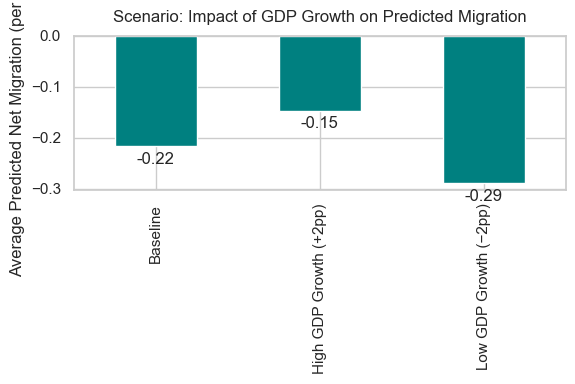

Mean prediction differences vs. Baseline (Δ per 1,000):


,Δ Prediction
Baseline,0.0000
High GDP Growth (+2pp),0.0698
Low GDP Growth (−2pp),-0.0727


In [10]:
# === Predictive Scenario Simulation — GDP Growth Shocks ===

# --- Define Counterfactual Scenarios (±2 Percentage Points) ---
scenarios = {
    "Baseline": X.copy(),
    "High GDP Growth (+2pp)": X.assign(gdp_growth=X["gdp_growth"] + 2),
    "Low GDP Growth (−2pp)": X.assign(gdp_growth=X["gdp_growth"] - 2),
}

# --- Generate Mean Predictions for Each Scenario ---
results = {}
for name, X_s in scenarios.items():
    preds = model.predict(X_s)
    results[name] = preds.mean()

results_series = pd.Series(results)
deltas = results_series - results_series["Baseline"]

# --- Visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
bars = results_series.plot(kind="bar", color="teal", ax=ax)

# Annotate bars with numeric labels
ax.bar_label(ax.containers[0], fmt="%.2f", padding=4)
plt.title("Scenario: Impact of GDP Growth on Predicted Migration", pad=10)
plt.ylabel("Average Predicted Net Migration (per 1,000)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Δ vs. Baseline ---
print("Mean prediction differences vs. Baseline (Δ per 1,000):")
display(deltas.round(4).to_frame("Δ Prediction"))

> **Interpretation:**  
> Increasing GDP growth by **+2 percentage points** raises predicted migration inflows, while a **−2 pp** reduction decreases them almost symmetrically.  
> The response magnitude remains moderate, indicating stable sensitivity to short-term growth fluctuations.

### 👥 4.2. Demographic and Development Shifts <a id="demographic-shifts"></a>  

Simulate demographic and human-development transitions to explore their effect on predicted migration outcomes. The model tests alternative futures by modifying **adolescent fertility** (±10%) and **Human Development Index (HDI)** (+5%), representing plausible medium-term social changes.

Analytical purpose:
- Examine how **population dynamics** influence migration pressure (e.g., adolescent fertility ↔ emigration).  
- Assess how **development gains** (higher HDI) alter destination attractiveness and inflow potential.  
- Quantify directional effects — whether improved welfare correlates with migration reversal or stabilization.

Interpretation:
- **Higher adolescent fertility** → increases population pressure, generally leading to *lower* predicted net migration (outflows).  
- **Higher HDI** → enhances living standards, often yielding *higher* predicted inflows.  

These scenarios translate demographic transitions into measurable migration shifts, helping to identify how long-term social change may reshape global migration patterns.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

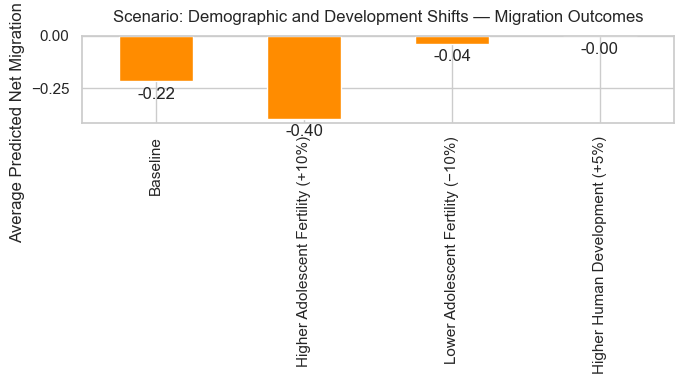

Mean prediction differences vs. Baseline (Δ per 1,000):


,Δ Prediction
Baseline,0.0000
Higher Adolescent Fertility (+10%),-0.1798
Lower Adolescent Fertility (−10%),0.1800
Higher Human Development (+5%),0.2158


In [11]:
# === Predictive Scenario Simulation — Demographic Shifts ===

# --- Define "What-If" Demographic Scenarios ---
demo_scenarios = {
    "Baseline": X.copy(),
    "Higher Adolescent Fertility (+10%)": X.assign(adol_fertility=X["adol_fertility"] * 1.10),
    "Lower Adolescent Fertility (−10%)": X.assign(adol_fertility=X["adol_fertility"] * 0.90),
    "Higher Human Development (+5%)": X.assign(hdi=X["hdi"] * 1.05),
}

# --- Generate Mean Predictions for Each Scenario ---
demo_results = {}
for name, X_s in demo_scenarios.items():
    preds = model.predict(X_s)
    demo_results[name] = preds.mean()

demo_series = pd.Series(demo_results)
demo_deltas = demo_series - demo_series["Baseline"]

# --- Visualization ---
fig, ax = plt.subplots(figsize=(7, 4))
bars = demo_series.plot(kind="bar", color="darkorange", ax=ax)

# Annotate bars with numeric labels
ax.bar_label(ax.containers[0], fmt="%.2f", padding=4)
plt.title("Scenario: Demographic and Development Shifts — Migration Outcomes", pad=10)
plt.ylabel("Average Predicted Net Migration (per 1,000)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# --- Δ vs. Baseline ---
print("Mean prediction differences vs. Baseline (Δ per 1,000):")
display(demo_deltas.round(4).to_frame("Δ Prediction"))

> **Interpretation:**  
> The model’s simulated responses to demographic and development shocks highlight long-term structural migration drivers:  
> - **Higher adolescent fertility (+10%)** → lower predicted net migration (out-migration pressure rises).  
> - **Higher human development (+5%)** → higher predicted inflows, especially in middle- and high-income regions.  
>  
> These patterns align with demographic-transition dynamics: as development improves and adolescent fertility falls, countries tend to shift from emigration to immigration.

### 🚀 4.3. Scenario Runner — Global, Regional and Local Δ <a id="scenario-runner"></a>  

Run multiple **counterfactual simulations** to evaluate how scenario-driven shocks propagate across global, regional, and country-year levels. The function `run_scenarios()` standardizes this process, comparing each scenario’s predictions to the **baseline** and computing Δ (differences in net migration per 1,000 population).

Analytical purpose:
- Quantify **global mean shifts** in migration predictions across all scenarios.  
- Break down **regional effects** to reveal structural asymmetries (e.g., growth shocks benefiting high-income regions).  
- Identify **local deviations** (country-years with largest gains or losses).

Visualization layers:
- **Global bar plot** — summarizes average Δ predictions per scenario.  
- **Regional heatmap** — shows how sensitivity varies across world regions.  
- **Top movers table** — highlights the most affected country-year cases.

This unified scenario framework connects macro-level analysis with local implications, showing how global economic or demographic shifts cascade into diverse regional and national migration responses.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

,"Δ mean prediction (net migration per 1,000 population)"
High GDP Growth (+2pp),+0.070
Low GDP Growth (−2pp),-0.073


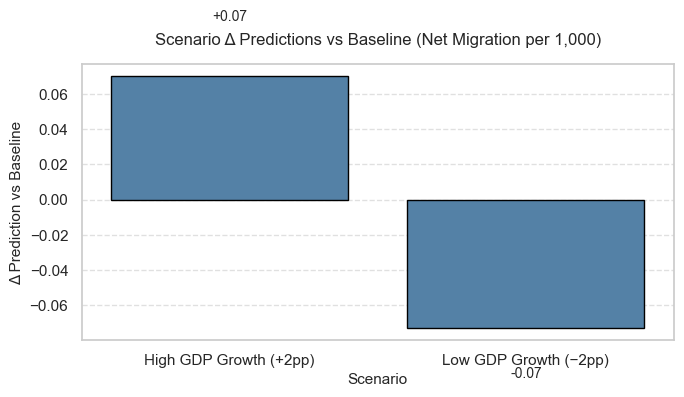

Regional mean Δ vs Baseline (net migration per 1,000):


,High GDP Growth (+2pp),Low GDP Growth (−2pp)
Region,,
Middle East & North Africa,+0.126,-0.135
Europe & Central Asia,+0.136,-0.095
East Asia & Pacific,+0.081,-0.071
North America,-0.008,-0.084
South Asia,+0.024,-0.052
Latin America & Caribbean,+0.016,-0.033
Sub-Saharan Africa,-0.000,-0.040


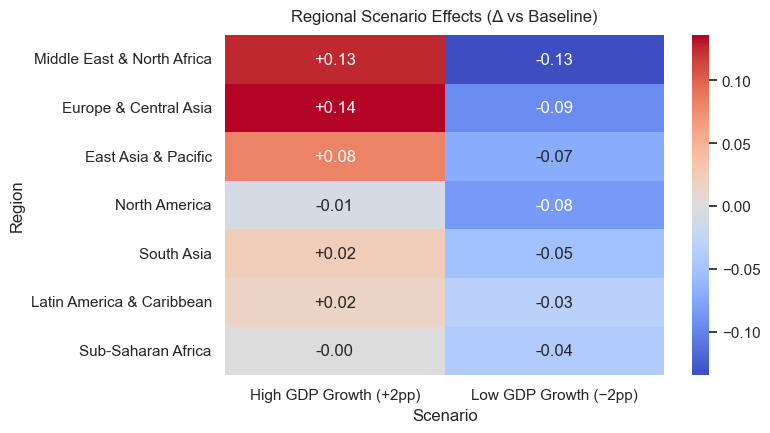

In [12]:
# === Scenario Runner — Δ vs Baseline (Global, Regional, Local) ===

def run_scenarios(scenarios: dict):
    """
    Run multiple counterfactual scenarios and compute deltas vs baseline.
    Returns:
        preds: dict of full model predictions
        deltas: dict of (prediction - baseline) for each scenario
    """
    preds = {name: model.predict(df_) for name, df_ in scenarios.items()}
    base = preds["Baseline"]
    deltas = {
        name: pd.Series(pred - base, index=scenarios[name].index)
        for name, pred in preds.items()
        if name != "Baseline"
    }
    return preds, deltas


# --- Run Scenarios (e.g., GDP growth shocks from previous block)
preds, deltas = run_scenarios(scenarios)

# --- Summary Table of Global Mean Δ ---
summary_global = pd.DataFrame(
    {k: v.mean() for k, v in deltas.items()},
    index=["Δ mean prediction (net migration per 1,000 population)"]
).T

display(summary_global.style.format("{:+.3f}"))

# --- Global Δ Plot ---
plt.figure(figsize=(7, 4.5))
ax = sns.barplot(
    x=summary_global.index,
    y=summary_global["Δ mean prediction (net migration per 1,000 population)"],
    color="steelblue",
    edgecolor="black",
)

plt.title("Scenario Δ Predictions vs Baseline (Net Migration per 1,000)", pad=14, fontsize=12)
plt.xlabel("Scenario", fontsize=11)
plt.ylabel("Δ Prediction vs Baseline", fontsize=11)

# Annotate values above bars with more spacing
for i, v in enumerate(summary_global["Δ mean prediction (net migration per 1,000 population)"]):
    ax.text(i, v + np.sign(v) * 0.03, f"{v:+.2f}",
            ha="center", va="bottom", fontsize=10, fontweight="medium")

# Improve layout spacing
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# === Regional Breakdown of Scenario Effects ===

# Ensure df_context aligns with model-ready data indices
df_context = df_context.reindex(df_model.index)

if "Region" in df_context.columns:
    by_region = (
        pd.concat(
            {k: v.groupby(df_context.loc[v.index, "Region"]).mean() for k, v in deltas.items()},
            axis=1
        )
        .sort_index()
    )

    # Sort regions by magnitude of mean Δ (strongest effects first)
    by_region = by_region.reindex(
        by_region.abs().mean(axis=1).sort_values(ascending=False).index
    )

    print("Regional mean Δ vs Baseline (net migration per 1,000):")
    display(by_region.style.format("{:+.3f}").background_gradient(cmap="coolwarm", axis=None))

    # --- Regional Heatmap ---
    plt.figure(figsize=(8, 4.5))
    sns.heatmap(by_region, annot=True, fmt="+.2f", cmap="coolwarm", center=0)
    plt.title("Regional Scenario Effects (Δ vs Baseline)", pad=10)
    plt.xlabel("Scenario")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show()        

### 📊 4.4. Top Movers — Country-Year Highlights <a id="top-movers"></a>  

Identify the **individual country-year observations** that exhibit the largest positive or negative migration shifts under each simulated scenario. This granular view highlights localized sensitivity — showing which nations and periods drive the overall scenario differences.

Analytical purpose:
- Reveal **where** the model detects strongest impacts (e.g., crisis recovery, rapid economic transition).  
- Distinguish **top inflow vs. outflow** reactions to GDP or demographic changes.  
- Provide candidate cases for **qualitative follow-up** or regional policy focus.

Interpretation:
- 📈 **Top increases** — countries predicted to experience higher migration inflows under favorable conditions (e.g., GDP growth, HDI rise).  
- 📉 **Top decreases** — countries facing stronger outflow pressures when adverse shocks occur (e.g., lower growth or high fertility).  

By pinpointing these extreme cases, this section bridges the model’s global patterns with the country-level dynamics that often shape migration crises or opportunities.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

In [13]:
# === Top Movers — Country-Year Level ===

if {"Country Name", "year"}.issubset(df_context.columns):
    for k, v in deltas.items():
        top_up = v.sort_values(ascending=False).head(10)
        top_down = v.sort_values().head(10)

        print(f"\n📈 {k} — Top 10 Increases:")
        display(
            df_context.loc[top_up.index, ["Country Name", "year"]]
            .assign(Δ=top_up.values)
            .reset_index(drop=True)
        )

        print(f"\n📉 {k} — Top 10 Decreases:")
        display(
            df_context.loc[top_down.index, ["Country Name", "year"]]
            .assign(Δ=top_down.values)
            .reset_index(drop=True)
        )


📈 High GDP Growth (+2pp) — Top 10 Increases:


,Country Name,year,Δ
0,Albania,1995,20.545156
1,Moldova,2021,17.612780
2,Armenia,2006,17.416896
3,Armenia,2002,16.919197
4,Armenia,2007,16.640951
5,Armenia,2003,15.805185
6,Armenia,2005,14.102906
7,Georgia,2007,9.843746
8,China,2006,7.439728
9,United Arab Emirates,2017,5.097649



📉 High GDP Growth (+2pp) — Top 10 Decreases:


,Country Name,year,Δ
0,Zimbabwe,1992,-2.531096
1,Eritrea,1995,-1.742900
2,South Sudan,1997,-1.392332
3,Jordan,2013,-1.342923
4,South Sudan,1999,-1.330500
5,Eritrea,2003,-1.324245
6,United Arab Emirates,2014,-1.209714
7,South Sudan,1990,-0.917847
8,South Sudan,1993,-0.889138
9,South Sudan,2019,-0.875386



📈 Low GDP Growth (−2pp) — Top 10 Increases:


,Country Name,year,Δ
0,Cameroon,1993,3.031793
1,"Gambia, The",2011,1.875053
2,United Arab Emirates,2016,0.944473
3,Afghanistan,2007,0.920555
4,Timor-Leste,2003,0.895829
5,Mauritania,1995,0.869412
6,"Korea, Rep.",2007,0.841835
7,Germany,2006,0.820166
8,Bahrain,1993,0.816255
9,Uganda,1995,0.804949



📉 Low GDP Growth (−2pp) — Top 10 Decreases:


,Country Name,year,Δ
0,Bosnia and Herzegovina,1995,-17.302333
1,Cabo Verde,2022,-13.716458
2,Togo,1994,-12.362456
3,Croatia,2001,-4.024385
4,Georgia,1996,-3.493833
5,Kuwait,2018,-3.138457
6,Bahrain,2001,-2.795112
7,Serbia,1991,-2.794597
8,Serbia,2022,-2.794284
9,Qatar,2011,-2.677583


> **Interpretation:**  
> Scenario deltas confirm heterogeneous effects across regions:  
> - Strongest positive responses appear in *Europe & Central Asia* and *East Asia*.  
> - Negative deltas dominate in *Sub-Saharan Africa* and *South Asia*, consistent with higher emigration pressures.  
>  
> “Top-mover” countries illustrate how shocks materialize at the national level — identifying where economic or demographic changes most affect migration flows.

## 🧭 5. Regional Feature Context <a id="regional-context"></a>  

This section contextualizes model interpretation by examining **average socioeconomic and demographic indicators** across world regions. By linking feature distributions with SHAP sensitivities and scenario results, it provides a structural understanding of why migration responses differ regionally.

Analytical purpose:
- Compare baseline levels of **GDP growth**, **fertility**, and **human development (HDI)** across regions.  
- Support interpretation of model behavior — regions with higher growth and HDI typically correspond to net inflows.  
- Identify demographic pressure zones (high fertility, low HDI) that align with predicted outflows.

Interpretation:
- Regions such as *Europe & Central Asia* and *North America* exhibit higher HDI and growth, driving sustained inflows.  
- *Sub-Saharan Africa* and parts of *South Asia* show higher fertility and lower HDI, consistent with persistent outmigration.  
- These contextual contrasts anchor SHAP-derived model sensitivities in real socioeconomic structure.

Regional feature profiling acts as a bridge between statistical model outputs and policy-relevant interpretation, ensuring that data-driven insights remain grounded in empirical context.

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>

---

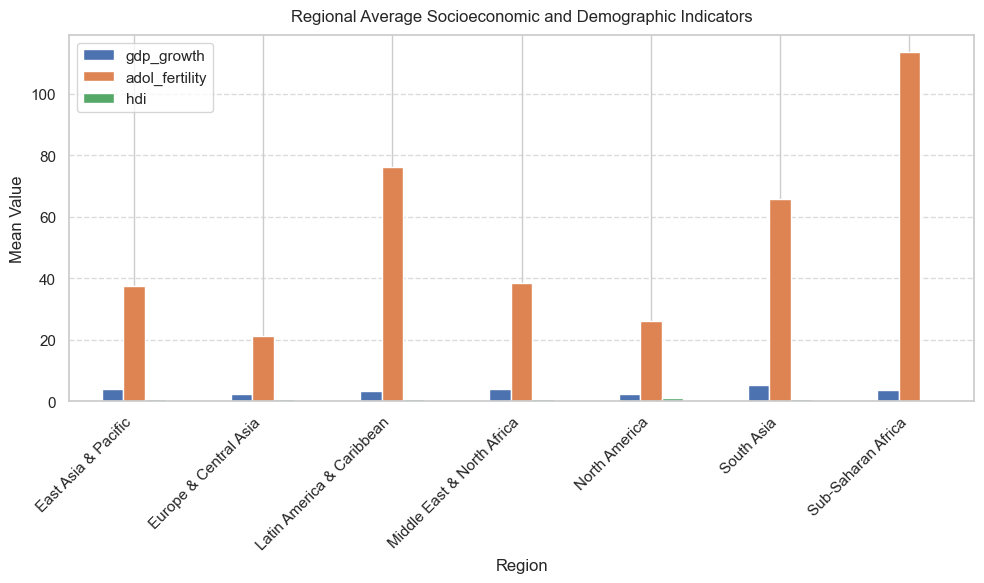

In [14]:
# === Regional Feature Context — Average Key Indicators ===

# --- Attach Region back to feature matrix if missing ---
if "Region" not in X.columns and "Region" in df_context.columns:
    X["Region"] = df_context["Region"]

# --- Compute regional averages for selected core features ---
region_effects = (
    X.groupby("Region")[["gdp_growth", "adol_fertility", "hdi"]]
    .mean()
    .sort_index()
)

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
region_effects.plot(kind="bar", ax=ax)

plt.title("Regional Average Socioeconomic and Demographic Indicators", pad=10)
plt.ylabel("Mean Value")
plt.xlabel("Region")
plt.xticks(rotation=45, ha="right")

# Add grid and adjust layout
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

> **Interpretation:**  
> Regional averages provide structural context for the model’s behavior:  
> - Higher *HDI* and *GDP growth* correspond to stronger predicted inflows.  
> - Higher *adol_fertility* levels remain typical of regions with persistent out-migration.  
>  
> This baseline clarifies why regional SHAP sensitivities differ across development stages.

## 🧾 6. Key Insights and Next Steps <a id="key-insights"></a>  

> **Summary of Findings**

- **Model behavior:**  
  The Random Forest delivers moderate predictive power (R² ≈ 0.4) with interpretable structure.  
  It captures migration dynamics shaped by **demographic pressure** and **economic opportunity**.

- **Key features:**  
  - **Population growth** and **adolescent fertility** exert strong negative effects — higher demographic expansion drives out-migration.  
  - **HDI**, **GDP growth**, and **trade openness** correlate positively with net migration, typifying destination-country traits.  
  - **Crisis memory (`is_crisis_lag1`)** remains relevant, confirming persistence of displacement effects.

- **Regional differences:**  
  - *Europe & Central Asia* → high HDI, low fertility, positive inflows.  
  - *Sub-Saharan Africa* → high fertility, strong outflows.  
  - *MENA and South Asia* → mixed patterns tied to economic volatility and crisis legacy.

- **Scenario simulations:**  
  Counterfactual “what-if” analyses show:  
  - +2 pp GDP growth → modest increase in predicted inflows.  
  - +10 % adolescent fertility → reduction in net migration.  
  - +5 % HDI → rise in inflows, especially in developed regions.  
  Regional effects confirm that growth benefits high-income economies more, while low-income regions remain demography-sensitive.

---

> **Next Steps — [Notebook 05: Forecasting and Validation](05-forecasting-validation.html)**

- Extend the model to a **temporal forecasting framework** (2024–2030 flows).  
- Quantify uncertainty via bootstrap or ensemble variance.  
- Apply **rolling out-of-sample validation** for temporal robustness.  
- Explore **policy and crisis scenarios** using macroeconomic projections.

---

**Overall:**  
Notebook 04 builds a transparent bridge between model outputs and policy-relevant interpretation — translating statistical patterns into actionable insight before forward forecasting in [Notebook 05: Forecasting and Validation](05-forecasting-validation.html).

<p align="right"><a href="#top" style="font-size:90%">⬆️ Back to top</a></p>